<img align="left" src="https://www.taborelec.com/Pictures/logo.png">

# Testing Markers and Markers Tweaking

### Description:
This script comes to demonstrate downloading markers to a Proteus device and operation that can be done on markers.


### set up:
It is recommended to have a device with 4 channels and connect a scoop to marker 1.
This scripts supports connection via LAN and PXI

### Proteus version: 
Anabelle


In [1]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
import os
import sys
import gc
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst

In [3]:
# a function that shows me the wave I created as f(x)
def plot(x,y):
    fig = plt.figure()   
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # plot the function
    plt.plot(x,y, 'g')

    # show the plot
    plt.show()
    
'''
a function that build a squre wave with the following parameters: 
@param  start_x: the start point of x 
@param  end_x: the end point of x 
@param How much points to create
@param  end_x: How much cycles 
@returns x and y     
'''
def prepare_squre_wave(start_x,end_x,num_points,cycle_num):
    x = np.linspace(start_x, end_x, num_points , endpoint=False)
    y = signal.square(2 * np.pi * cycle_num * x)
    #plot(x,y)
    return x,y  
    

In [4]:
# Connect to instrument

inst = None
admin = None

conn_msg_str = ''

def disconnect():
    global inst
    global admin
    if inst is not None:
        try:
            inst.close_instrument()            
        except:
            pass
        inst = None
    if admin is not None:
        try:
            admin.close_inst_admin()
        except:
            pass
        admin = None
    gc.collect()

def connect_to_pxi_slot(slot_id):
    global inst
    global admin
    try:
        disconnect()        
        admin = TEProteusAdmin()
        admin.open_inst_admin()        
        inst = admin.open_instrument(slot_id, reset_hot_flag=True)
    except:
        pass

def connect_to_lan_server(ip_address):
    global inst
    try:
        disconnect()
        inst = TEVisaInst(ip_address, port=5025)
    except:
        pass

def connect(ipaddr_or_slotid):
    try:
        disconnect()
        if isinstance(ipaddr_or_slotid, str) and '.' in ipaddr_or_slotid:
            connect_to_lan_server(ipaddr_or_slotid)
        else:
            connect_to_pxi_slot(ipaddr_or_slotid)
    except:
        pass

addr_textbox = widgets.Text(
    value='',
    placeholder='IP Address or Slot Id',
    description='Address:',
    disabled=False
)

output = widgets.Output()

def print_conn_message(msg_str):
    global output
    global conn_msg_str
    with output:
        if len(conn_msg_str) > 0:
            print('\r', end='')
            print(' ' * len(conn_msg_str), end='')
            print('\r', end='')
        conn_msg_str = str(msg_str)
        if len(conn_msg_str) > 0:
            print(conn_msg_str, end='')

def on_button_connect_clicked(b):
    global inst
    global addr_textbox
    print_conn_message('')
    disconnect()
    if addr_textbox is not None:
        conn_str = addr_textbox.value
        if conn_str:
            print_conn_message('Connecting to {0} ..'.format(conn_str))
            connect(conn_str)
            print_conn_message('')
    if inst is not None:
        idn_str = inst.send_scpi_query('*IDN?')
        if idn_str:
            print_conn_message('Connected to: ' + idn_str.strip())
    
def on_button_disconnect_clicked(b):
    print_conn_message('')
    disconnect()

btn_connect = widgets.Button(description="Connect")
btn_disconnect = widgets.Button(description="Disconnect")

btn_connect.on_click(on_button_connect_clicked)
btn_disconnect.on_click(on_button_disconnect_clicked)

display(addr_textbox, btn_connect, btn_disconnect, output)

Text(value='', description='Address:', placeholder='IP Address or Slot Id')

Button(description='Connect', style=ButtonStyle())

Button(description='Disconnect', style=ButtonStyle())

Output()

In [134]:
print ('Reset instrument ..')
paranoia_level=2
# Reset the instrument
inst.send_scpi_cmd( '*CLS; *RST', paranoia_level)
inst.send_scpi_cmd( ':TRACe:DELete:ALL', paranoia_level)
inst.send_scpi_cmd(":INIT:CONT ON")

# Get the model name
model = inst.send_scpi_query(":SYST:iNF:MODel?")
print("Model: " + model)

# Infer the natural DAC waveform format
if 'P908' in model:
    dac_mode = 8
else:
    dac_mode = 16
print("DAC waveform format: {0} bits-per-point".format(dac_mode))

# Get number of channels
resp = inst.send_scpi_query(":INST:CHAN? MAX")
print("Number of channels: " + resp)
num_channels = int(resp)

# Get the maximal number of segments
resp = inst.send_scpi_query(":TRACe:SELect:SEGMent? MAX")
print("Max segment number: " + resp)
max_seg_number = int(resp)

# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.send_scpi_query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0 

Reset instrument ..
Model: P9484M
DAC waveform format: 16 bits-per-point
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 17,171,429,312 wave-bytes


In [135]:
FREQ = 2500
inst.send_scpi_cmd(":FREQ:RAST {0}MHz".format(FREQ))
resp = inst.send_scpi_query(":FREQ:RAST?")
freq = float(resp)
print ("DAC Generate Freq:{0}".format(freq))

DAC Generate Freq:2500000000.0


## Prepare waveform's and marker's data for segments


In [143]:
# Build wave-data and markers-data for 12 segments

print('Build wave-data and markers-data ..')
seg_wave_points = 4096
ncycles =  1
cyclelen = seg_wave_points/ncycles

wave = [ None ]
mark = [ None ]

# Buffer size for the waveform
if dac_mode == 16:
    seg_wave_bytes = seg_wave_points * 2 # each point is 2 bytes in size
else:
    seg_wave_bytes = seg_wave_points

#seg_wave_bytes = seg_wave_points * 2 # each waveform point is represented as uint16 (2 bytes in size)

# Buffer size for Marker
if dac_mode == 16 and freq <= 2500000000:
        seg_mark_bytes = seg_wave_points // 4
else:
        seg_mark_bytes = seg_wave_points // 8

# Build wave
x = np.linspace(start=0, stop=seg_wave_points, num=seg_wave_points, endpoint=False)
yw = np.fmod(x, cyclelen)
yw = (yw <= cyclelen / 2) * max_dac
yw = np.round(yw)
yw = np.clip(yw, 0, max_dac)
yw = yw.astype(data_type)

yw.reshape(-1) # = yw.astype(data_type)

   
# Build marker  
'''
x = np.linspace(
    start=0, stop=seg_mark_bytes, num=seg_mark_bytes, endpoint=False)
y = np.fmod(x, seg_mark_bytes)
y = (y <= seg_mark_bytes / 2) * 0x33
y = np.round(y)
#y = np.clip(y, 0, 255)
#y= np.ones(seg_mark_bytes,np.uint8) *0xFF
mark = y
'''
mark= np.zeros(seg_mark_bytes, np.uint8)
if dac_mode == 16 and freq <= 2500000000:
    mark[0] = 0x21
    mark[1] = 0x3
    mark[2] = 0x33
    mark[3] = 0x0
    mark[4] = 0x0
    mark[5] = 0x0
    mark[127] = 0x3
    mark[128] = 0x3
    mark[255] = 0x3
    mark[511] = 0x3
    mark[512] = 0x3
    mark[768] = 0x33
    mark[1000] = 0x33
    
else:
    mark[0] = 0x33
    mark[1] = 0x33
    mark[2] = 0x33
    mark[3] = 0x33
    mark[4] = 0x33
    mark[5] = 0x33
    mark[6] = 0x33
    mark[7] = 0x33
    mark[8] = 0x33
    mark[9] = 0x33
    mark[10] = 0x33
    mark[11] = 0x33
    mark[510] = 0x33
    

    #mark[13] = 0x1
    #mark[14] = 0x2
    #mark[15] = 0x1
    #mark[16] = 0x2
    #mark[17] = 0x1
    #mark[18] = 0x2
'''
else:
    mark[0] = 0x3
    mark[127] = 0x3
    mark[128] = 0x3
    mark[255] = 0x3
    mark[511] = 0x3
    
else:
    for i in range(0,512,16):
        mark[i+0] = 0x21
        mark[i+1] = 0x21
        mark[i+2] = 0x12
        mark[i+3] = 0x12
        mark[i+4] = 0x33
        mark[i+5] = 0x33
        mark[i+6] = 0x0
        mark[i+7] = 0x0
        mark[i+8] = 0x21
        mark[i+9] = 0x21
        mark[i+10] = 0x12
        mark[i+11] = 0x12
        mark[i+12] = 0x33
        mark[i+13] = 0x33
        mark[i+14] = 0x0
        mark[i+] = 0x0
'''

#mark = y.astype(np.uint8).reshape(-1)

#del x, y
    
print('Done')   
 

Build wave-data and markers-data ..
Done


<IPython.core.display.Javascript object>


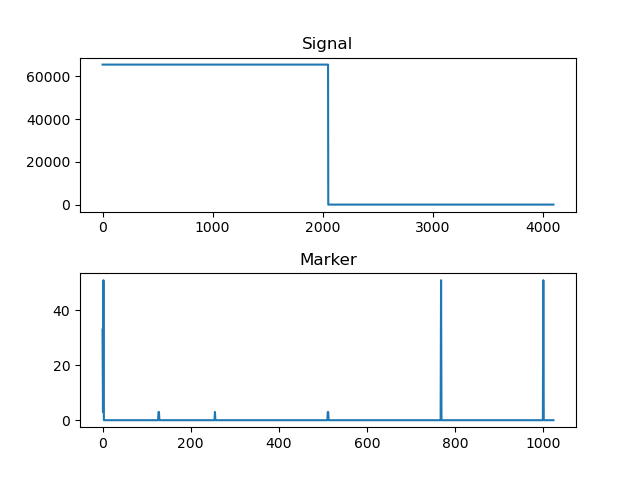

uint16


In [144]:
fig = plt.figure()
plt1 = fig.add_subplot(211)
plt2 = fig.add_subplot(212)
plt1.plot(yw)
plt1.set_title('Signal')
plt2.plot(mark)
plt2.set_title('Marker')
fig.subplots_adjust(hspace=.4,wspace=0.5)
plt.show()
print( yw.dtype)

In [145]:
print(mark[0:32])
print(len(mark))

[33  3 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
1024


## Download waveform data to segments

In [146]:
# Download segments

# data-type code: 'B' = uint8, 'H' = uint16
#wav_dat_type = 'H' if dac_mode == 16 else 'B'
#mrk_dat_type = 'B'


channb = 1
segnum = 1
wav = yw
mrk = mark
print('Download wave to segment {0} of channel {1}'.format(segnum, channb))
print('Number of wave point:{0}'.format(seg_wave_points))

# Select channel
cmd = ':INST:CHAN {0}'.format(channb)
inst.send_scpi_cmd( cmd, paranoia_level)

# Define segment
cmd = ':TRAC:DEF {0},{1}'.format(segnum, seg_wave_points)
inst.send_scpi_cmd( cmd, paranoia_level)

# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd( cmd, paranoia_level)

# Increase the timeout before writing binary-data:
inst.timeout = 30000

# Send the binary-data with *OPC? added to the beginning of its prefix.
#inst.write_binary_values('*OPC?; :TRAC:DATA', wav, datatype=wav_dat_type)
inst.write_binary_data(':TRAC:DATA', yw)

# Read the response to the *OPC? query that was added to the prefix of the binary data
#resp = inst.read()

# Set normal timeout
inst.timeout = 10000

resp = inst.send_scpi_query(':SYST:ERR?')
resp = resp.rstrip()
if not resp.startswith('0'):
    print('ERROR: "{0}" after writing binary values'.format(resp))





Download wave to segment 1 of channel 1
Number of wave point:4096


## Play Waveform data

In [147]:
inst.send_scpi_cmd(':INST:CHAN 1')


inst.send_scpi_cmd('FUNC:MODE ARB')
# Play the specified segment at the selected channel:
cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
inst.send_scpi_cmd( cmd, paranoia_level)

resp = inst.send_scpi_cmd(':OUTP OFF')
inst.send_scpi_cmd(':SOUR:VOLT 0.4')
# Turn on the output of the selected channel:


resp = inst.send_scpi_cmd(':OUTP ON')

inst.send_scpi_cmd('*TRG')
resp = inst.send_scpi_query(':SYST:ERR?')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
#inst.send_scpi_cmd('FUNC:MODE CONT')


0, no error


## Download markers-data to segments

In [148]:
print('Download markers to segment {0} of channel {1}'.format(segnum, channb))

# Increase the timeout before writing binary-data:
inst.timeout = 30000

# Send the binary-data with *OPC? added to the beginning of its prefix.
inst.send_scpi_cmd(":INST:CHAN 1") 
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd( cmd, paranoia_level)
inst.write_binary_data(':MARK:DATA',mark)

# Read the response to the *OPC? query that was added to the prefix of the binary data
#resp = inst.read()

# Set normal timeout
inst.timeout = 10000

resp = inst.send_scpi_query(':SYST:ERR?')
resp = resp.rstrip()
if not resp.startswith('0'):
    print('ERROR: "{0}" after writing binary values'.format(resp))


Download markers to segment 1 of channel 1


## Play out marker's data

In [149]:
# Turn on the markers of the selected channel    
resp = inst.send_scpi_query(':MARK:SEL? MAX')
resp = resp.rstrip()
markers_per_chan = int(resp)
print ("Markers per channel:{0}".format(markers_per_chan))

inst.send_scpi_cmd(':MARK:SEL 1')
inst.send_scpi_cmd(':MARK:STAT ON')
inst.send_scpi_cmd(':MARK:SEL 2')
inst.send_scpi_cmd(':MARK:STAT ON')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

print()


Markers per channel:2
0, no error



## Query the marker's FINE_DELAY registers value

In [ ]:
inst.send_scpi_cmd(':MARK:SEL 1')
resp = inst.send_scpi_query(':MARK:DEL:COAR?')
print(resp)
resp = inst.send_scpi_query(':MARK:DEL:FIN?')
print(resp)

inst.send_scpi_cmd(':MARK:SEL 2')
resp = inst.send_scpi_query(':MARK:DEL:COAR?')
print(resp)
resp = inst.send_scpi_query(':MARK:DEL:FIN?')
print(resp)

# Set Markers coarse and fine delay to align marker to channel 

In [ ]:
inst.send_scpi_cmd(':MARK:SEL 1')            #Select marker 1
inst.send_scpi_cmd(':MARK:DEL:COAR 8')       #Coarse delay adds delay in units of SCLK. In 9GS mode, resolution is 8SCLKs.
inst.send_scpi_cmd(':MARK:DEL:FIN 450e-12')  #Fine delay adds delay in picoseconds with a resolution of 5ps.

inst.send_scpi_cmd(':MARK:SEL 2')
inst.send_scpi_cmd(':MARK:DEL:COAR 8')
inst.send_scpi_cmd(':MARK:DEL:FIN 450e-12')

## [DEBUG]: Print register values

In [ ]:
import tempfile
import webbrowser

Debug = False

if Debug == True :
    channb = 1
    cmd = ':INST:CHAN {0}; :SYST:INF:REG?'.format(channb)
    html_str = inst.send_scpi_query(cmd, max_resp_len=200000)
    #print(html_str)
    with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html') as f:
        url = 'file://' + f.name
        f.write(html_str)
    webbrowser.open(url)

In [ ]:
del wave

# close connection
inst.close_instrument()